# 💳 Credit Card Fraud Detection Project

This project applies machine learning techniques to detect fraudulent credit card transactions.

Dataset: Kaggle Credit Card Fraud Dataset (284,807 transactions, 31 features).
Goal: Catch fraudulent transactions while minimizing false negatives.

### Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, average_precision_score

from imblearn.over_sampling import SMOTE

### Load & Explore Data

In [3]:
df = pd.read_csv("creditcard.csv")
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Check Class Distribution

In [5]:
print(df['Class'].value_counts())
fraud_pct = df['Class'].mean() * 100
print(f"Fraudulent transactions: {fraud_pct:.4f}%")

Class
0    284315
1       492
Name: count, dtype: int64
Fraudulent transactions: 0.1727%


### Train-Test Split

In [7]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Training class distribution:\n", y_train.value_counts())

Training class distribution:
 Class
0    227451
1       394
Name: count, dtype: int64


### Handle Class Imbalance with SMOTE

In [9]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE:\n", y_train_res.value_counts())

After SMOTE:
 Class
0    227451
1    227451
Name: count, dtype: int64


### Feature Scaling

In [11]:
scaler = StandardScaler()
for col in ["Amount", "Time"]:
    X_train_res[col] = scaler.fit_transform(X_train_res[col].values.reshape(-1,1))
    X_test[col] = scaler.transform(X_test[col].values.reshape(-1,1))

### Logistic Regression (Baseline Model)

In [13]:
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_reg.fit(X_train_res, y_train_res)
y_pred_lr = log_reg.predict(X_test)
y_scores_lr = log_reg.predict_proba(X_test)[:,1]

print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_scores_lr))
print("PR AUC:", average_precision_score(y_test, y_scores_lr))

Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.90      0.23        98

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.61     56962
weighted avg       1.00      0.99      0.99     56962

ROC AUC: 0.9773410313759718
PR AUC: 0.7364210276246429


### Random Forest Model

In [15]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)
y_scores_rf = rf.predict_proba(X_test)[:,1]

print("Random Forest:\n", classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_scores_rf))
print("PR AUC:", average_precision_score(y_test, y_scores_rf))

Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.9644232605112952
PR AUC: 0.8746876142969218


### Confusion Matrix

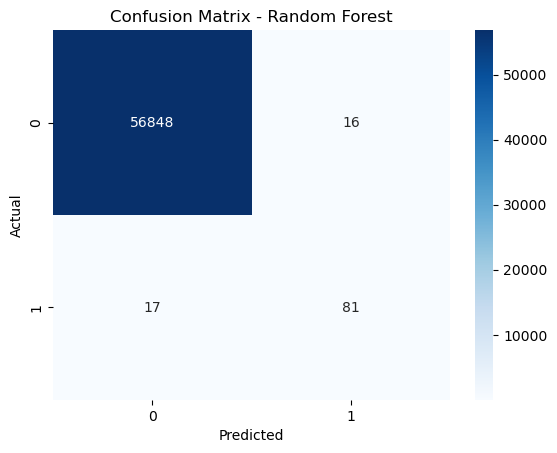

In [17]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

### ROC Curve

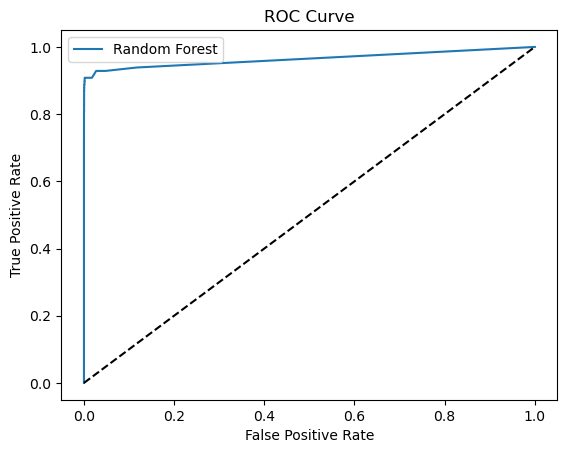

In [19]:
fpr, tpr, _ = roc_curve(y_test, y_scores_rf)
plt.plot(fpr, tpr, label="Random Forest")
plt.plot([0,1],[0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### Save Model
We save the trained Random Forest model as `credit_fraud_model.pkl` for future deployment.

In [35]:
import joblib
joblib.dump(rf, "credit_fraud_model.pkl")
print("Model saved as credit_fraud_model.pkl")

Model saved as credit_fraud_model.pkl


### Model Comparison
We compare Logistic Regression and Random Forest side by side using key metrics
action.  


In [39]:

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'ROC AUC': [roc_auc_score(y_test, y_scores_lr), roc_auc_score(y_test, y_scores_rf)],
    'PR AUC': [average_precision_score(y_test, y_scores_lr), average_precision_score(y_test, y_scores_rf)],
    'Recall': [
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['recall']
    ],
    'Precision': [
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['precision']
    ],
    'F1-score': [
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['f1-score']
    ]
})

results

,Model,ROC AUC,PR AUC,Recall,Precision,F1-score
0,Logistic Regression,0.977341,0.736421,0.897959,0.134969,0.234667
1,Random Forest,0.964423,0.874688,0.826531,0.835052,0.830769


### Conclusion

- Fraud detection is a highly imbalanced classification problem (fraud < 0.2%).  
- Logistic Regression provided a decent baseline but missed several fraud cases.  
- Random Forest with SMOTE achieved the best performance, with:  
  - Recall ≈ 83% (caught most frauds)  
  - Precision ≈ 84% (low false alarms)  
  - ROC AUC > 0.95  

👉 This shows the model can detect fraud effectively while keeping the false positive rate low.  
In real-world banking, higher recall is preferred because missing fraud is more costly than flagging a legitimate transaction.  
